# Notes
**Supposed to be used as a sort of showcase of how to use the tool**

*Unfinished, just a draft*

- Whenever a critical error occurs, we should think of it as also being a corruption error

In [11]:
%load_ext autoreload
%autoreload 2

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src import RegisterTree, Analyses, Config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
config = Config()
config.possible_configs

Config not set. Check possible_configs attribute, and use set_config()


{'coremark_hwsec': 'src/configs/coremark_hwsec.ini',
 'coremark': 'src/configs/coremark.ini'}

In [13]:

vanilla_conf = config.set_config("coremark")
hwsec_conf = Config("coremark_hwsec")

vanilla_reg_tree = RegisterTree(config)
hwsec_reg_tree = RegisterTree(hwsec_conf)

print(f"Could read the following files:")
for i, file_name in enumerate(vanilla_reg_tree.no_reg_runs):
    print(f"\t{file_name}")
    if i > 4:
        print("\t.\n\t.\n\t.")
        break

Running function _read_viable_seu_logs. Took: 8.32 seconds
Running function _create_register_tree. Took: 4.45 seconds
Running function _read_viable_seu_logs. Took: 3.79 seconds
Running function _create_register_tree. Took: 1.79 seconds
Could read the following files:
	seu_2023-09-13_05-48-18.106123
	seu_2023-09-13_05-47-52.279055
	seu_2023-09-13_05-48-14.854977
	seu_2023-09-13_05-48-18.106123
	seu_2023-09-13_05-47-52.279055
	seu_2023-09-13_05-48-14.854977
	.
	.
	.


## Showcase of the register tree
**Do more in the code, add search to tree, maybe show graphviz**

The data is accessed through a tree-structure, which follows the hierarchy of the given SoC. The code below shows some ways of interacting with this data-model

In [14]:
register_name = "ibex_soc_wrap.ibex_soc_i.ibex_wrap.u_top.u_ibex_top.gen_regfile_ff.register_file_i"
# register_name = "ibex_soc_wrap.ibex_soc_i"
node = vanilla_reg_tree.get_node_by_path(register_name)

print(node.soc_path)
print(node.name)
print(f"Number of hits on this element: \n\t{len(node.seu_log)}")

print("Names of children of this node:")
for i, child in enumerate(node.children):
    print("\t", child.name)
    
    if i > 4:
        print("\t.\n\t.\n\t.")
        break

ibex_soc_wrap.ibex_soc_i.ibex_wrap.u_top.u_ibex_top.gen_regfile_ff.register_file_i
register_file_i
Number of hits on this element: 
	6007
Names of children of this node:
	 rf_reg[13]
	 rf_reg[27]
	 rf_reg[20]
	 rf_reg
	 rf_reg[4]
	 rf_reg[22]
	.
	.
	.


In [15]:
mem0_name = "ibex_soc_wrap.ibex_soc_i.mem0"
mem0_node = vanilla_reg_tree.get_node_by_path(mem0_name)
mem0_node.seu_log

,seed_crc,list_crc,matrix_crc,state_crc,final_crc,coremark_score,injection_cycle,register,bit_number,value_before,value_after
seu_2023-09-12_05-40-19.450607,59893,59156,8151,36410,59156,4640560,99826,ibex_soc_wrap.ibex_soc_i.mem0.bram0.doutB,1,0,2
seu_2023-09-11_16-59-04.096565,59893,59156,8151,36410,59156,4640560,202406,ibex_soc_wrap.ibex_soc_i.mem0.bram0.doutB,2,0,4
seu_2023-09-12_02-00-21.080257,59893,59156,8151,36410,59156,4640560,364095,ibex_soc_wrap.ibex_soc_i.mem0.bram0.doutB,17,0,131072
seu_2023-09-12_19-45-04.890708,None,None,None,None,None,None,390958,ibex_soc_wrap.ibex_soc_i.mem0.bram0.doutA,14,5024387,5040771
seu_2023-09-12_19-12-20.617988,59893,59156,8151,36410,59156,4640560,348821,ibex_soc_wrap.ibex_soc_i.mem0.bram0.doutB,8,0,256
...,...,...,...,...,...,...,...,...,...,...,...
seu_2023-09-12_15-40-09.016062,59893,59156,8151,36410,59156,4640560,213875,ibex_soc_wrap.ibex_soc_i.mem0.bram0.doutB,23,0,8388608
seu_2023-09-13_14-13-22.148984,None,None,None,None,None,None,345869,ibex_soc_wrap.ibex_soc_i.mem0.bram0.doutA,13,31690787,31698979
seu_2023-09-12_01-37-19.054121,59893,59156,8151,36410,59156,4640560,79553,ibex_soc_wrap.ibex_soc_i.mem0.bram0.doutA,2,211847779,211847783
seu_2023-09-19_04-34-45.400745,59893,59156,8151,36410,59156,4640560,388877,ibex_soc_wrap.ibex_soc_i.mem0.bram0.doutB,5,0,32


## Showcase of Analyses class
This class is where we mainly carry out our analyses. For a given analysis we pass a node object, and a boolean specifying whether we want to plot the results.
Not all methods have plotting methods associated with them, but they will accept the argument, and print a message if they do not have a plotting method.

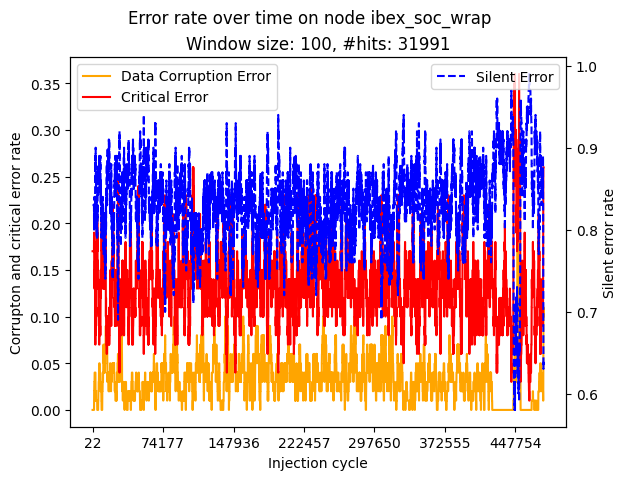

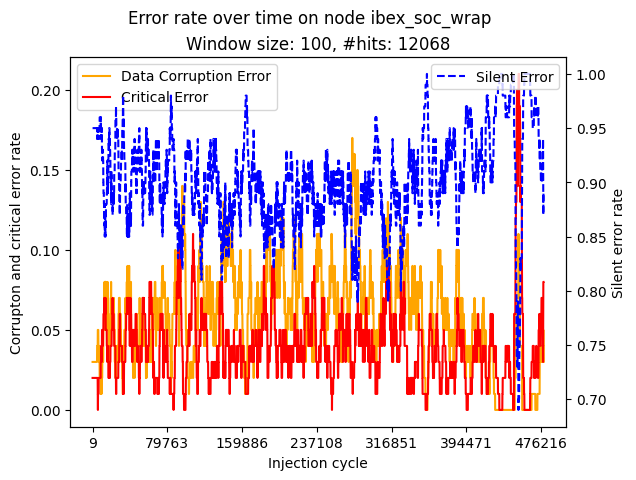

In [16]:
_ = Analyses.error_rate_over_time(vanilla_reg_tree.root, plot=True)
_ = Analyses.error_rate_over_time(hwsec_reg_tree.root, plot=True)

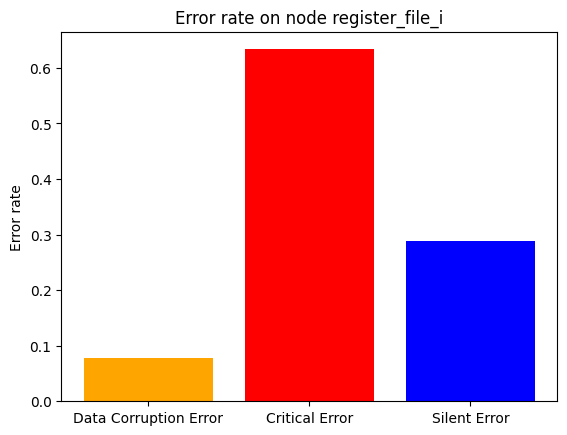

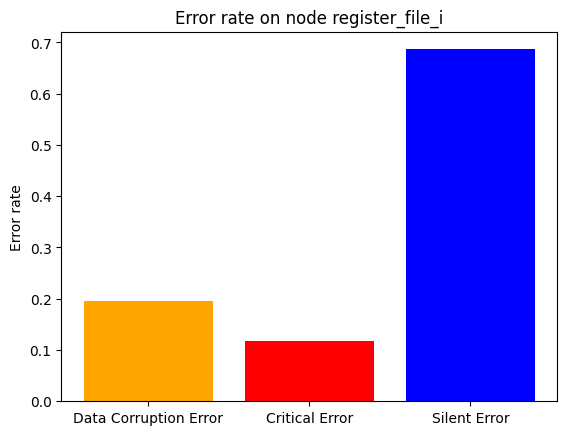

In [17]:
vanilla_node = vanilla_reg_tree.get_node_by_path(register_name)
hwsec_node = hwsec_reg_tree.get_node_by_path(register_name)

_ = Analyses.error_rate_by_type(vanilla_node, plot=True)
_ = Analyses.error_rate_by_type(hwsec_node, plot=True)

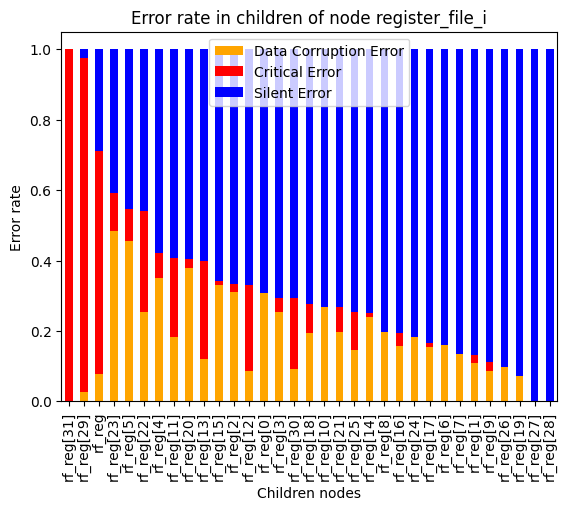

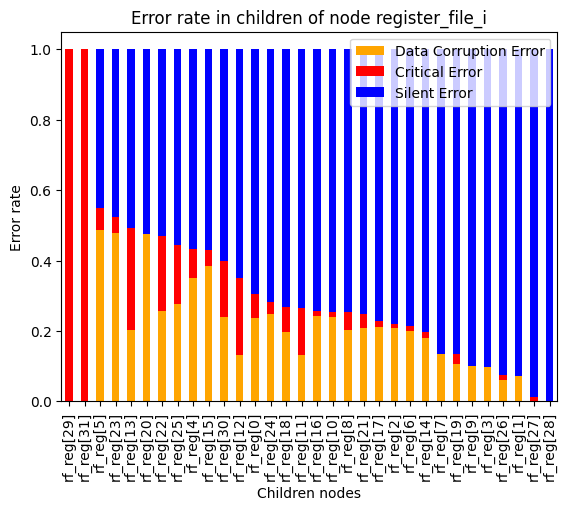

In [18]:
res, fig = Analyses.error_rate_by_type_in_children(vanilla_node, plot=True)
res, fig = Analyses.error_rate_by_type_in_children(hwsec_node, plot=True)